In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
batch_size = 128
learning_rate = 1e-3

transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='emotion5/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion5/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([128, 3, 48, 48])
out-size: torch.Size([3, 802, 402])


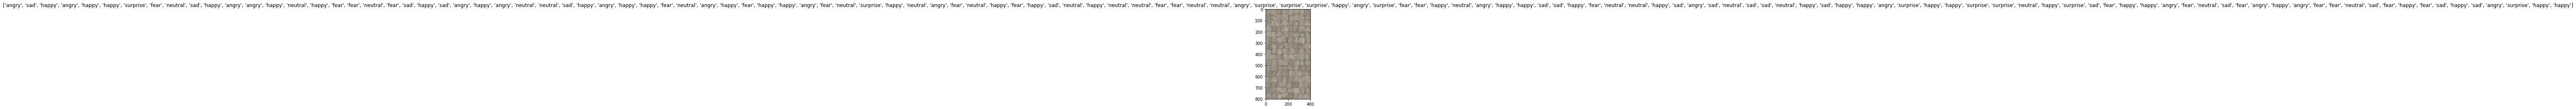

In [4]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [10]:
net = models.resnet18(pretrained=True)
net = net.cuda() if device else net
net

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Otakuking/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.fc = net.fc.cuda() if device else net.fc

In [7]:
n_epochs = 150
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet_adam_batch64_lr00001.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/150], Step [0/221], Loss: 5.1754
Epoch [1/150], Step [20/221], Loss: 4.9274
Epoch [1/150], Step [40/221], Loss: 4.8379
Epoch [1/150], Step [60/221], Loss: 4.8699
Epoch [1/150], Step [80/221], Loss: 4.7421
Epoch [1/150], Step [100/221], Loss: 4.6250
Epoch [1/150], Step [120/221], Loss: 4.6245
Epoch [1/150], Step [140/221], Loss: 4.4480
Epoch [1/150], Step [160/221], Loss: 4.1103
Epoch [1/150], Step [180/221], Loss: 4.2773
Epoch [1/150], Step [200/221], Loss: 4.1192
Epoch [1/150], Step [220/221], Loss: 4.0733

train-loss: 4.5568, train-acc: 10.1616
validation loss: 4.0369, validation acc: 25.4705

Improvement-Detected, save-model
Epoch 2

Epoch [2/150], Step [0/221], Loss: 3.8080
Epoch [2/150], Step [20/221], Loss: 4.0560
Epoch [2/150], Step [40/221], Loss: 3.4470
Epoch [2/150], Step [60/221], Loss: 3.4818
Epoch [2/150], Step [80/221], Loss: 3.7359
Epoch [2/150], Step [100/221], Loss: 3.0558
Epoch [2/150], Step [120/221], Loss: 3.0568
Epoch [2/150], Step [140/221], Loss

Epoch [13/150], Step [180/221], Loss: 0.7180
Epoch [13/150], Step [200/221], Loss: 0.5687
Epoch [13/150], Step [220/221], Loss: 0.5789

train-loss: 1.8183, train-acc: 83.8079
validation loss: 2.1780, validation acc: 56.4879

Epoch 14

Epoch [14/150], Step [0/221], Loss: 0.7375
Epoch [14/150], Step [20/221], Loss: 0.6773
Epoch [14/150], Step [40/221], Loss: 0.5357
Epoch [14/150], Step [60/221], Loss: 0.4312
Epoch [14/150], Step [80/221], Loss: 0.5632
Epoch [14/150], Step [100/221], Loss: 0.5611
Epoch [14/150], Step [120/221], Loss: 0.5677
Epoch [14/150], Step [140/221], Loss: 0.5930
Epoch [14/150], Step [160/221], Loss: 0.5413
Epoch [14/150], Step [180/221], Loss: 0.5475
Epoch [14/150], Step [200/221], Loss: 0.4889
Epoch [14/150], Step [220/221], Loss: 0.4226

train-loss: 1.7297, train-acc: 87.4332
validation loss: 2.1593, validation acc: 56.5304

Epoch 15

Epoch [15/150], Step [0/221], Loss: 0.5017
Epoch [15/150], Step [20/221], Loss: 0.4041
Epoch [15/150], Step [40/221], Loss: 0.3445


Epoch [26/150], Step [160/221], Loss: 0.0432
Epoch [26/150], Step [180/221], Loss: 0.0837
Epoch [26/150], Step [200/221], Loss: 0.0576
Epoch [26/150], Step [220/221], Loss: 0.0897

train-loss: 1.0192, train-acc: 99.5190
validation loss: 2.1856, validation acc: 56.5728

Epoch 27

Epoch [27/150], Step [0/221], Loss: 0.0521
Epoch [27/150], Step [20/221], Loss: 0.0403
Epoch [27/150], Step [40/221], Loss: 0.0469
Epoch [27/150], Step [60/221], Loss: 0.0377
Epoch [27/150], Step [80/221], Loss: 0.0391
Epoch [27/150], Step [100/221], Loss: 0.0430
Epoch [27/150], Step [120/221], Loss: 0.0310
Epoch [27/150], Step [140/221], Loss: 0.0405
Epoch [27/150], Step [160/221], Loss: 0.0394
Epoch [27/150], Step [180/221], Loss: 0.0698
Epoch [27/150], Step [200/221], Loss: 0.0648
Epoch [27/150], Step [220/221], Loss: 0.0386

train-loss: 0.9832, train-acc: 99.6145
validation loss: 2.1960, validation acc: 56.9266

Epoch 28

Epoch [28/150], Step [0/221], Loss: 0.0252
Epoch [28/150], Step [20/221], Loss: 0.0274

Epoch [39/150], Step [140/221], Loss: 0.0176
Epoch [39/150], Step [160/221], Loss: 0.0197
Epoch [39/150], Step [180/221], Loss: 0.0336
Epoch [39/150], Step [200/221], Loss: 0.0140
Epoch [39/150], Step [220/221], Loss: 0.0185

train-loss: 0.6897, train-acc: 99.7206
validation loss: 2.3210, validation acc: 56.8700

Epoch 40

Epoch [40/150], Step [0/221], Loss: 0.0227
Epoch [40/150], Step [20/221], Loss: 0.0158
Epoch [40/150], Step [40/221], Loss: 0.0096
Epoch [40/150], Step [60/221], Loss: 0.0142
Epoch [40/150], Step [80/221], Loss: 0.0102
Epoch [40/150], Step [100/221], Loss: 0.0222
Epoch [40/150], Step [120/221], Loss: 0.0240
Epoch [40/150], Step [140/221], Loss: 0.0108
Epoch [40/150], Step [160/221], Loss: 0.0186
Epoch [40/150], Step [180/221], Loss: 0.0089
Epoch [40/150], Step [200/221], Loss: 0.0494
Epoch [40/150], Step [220/221], Loss: 0.0129

train-loss: 0.6730, train-acc: 99.6817
validation loss: 2.3308, validation acc: 56.8700

Epoch 41

Epoch [41/150], Step [0/221], Loss: 0.007

Epoch [52/150], Step [120/221], Loss: 0.0065
Epoch [52/150], Step [140/221], Loss: 0.0054
Epoch [52/150], Step [160/221], Loss: 0.0350
Epoch [52/150], Step [180/221], Loss: 0.0490
Epoch [52/150], Step [200/221], Loss: 0.0073
Epoch [52/150], Step [220/221], Loss: 0.0344

train-loss: 0.5213, train-acc: 99.7100
validation loss: 2.4321, validation acc: 57.2096

Epoch 53

Epoch [53/150], Step [0/221], Loss: 0.0071
Epoch [53/150], Step [20/221], Loss: 0.0124
Epoch [53/150], Step [40/221], Loss: 0.0412
Epoch [53/150], Step [60/221], Loss: 0.0046
Epoch [53/150], Step [80/221], Loss: 0.0286
Epoch [53/150], Step [100/221], Loss: 0.0045
Epoch [53/150], Step [120/221], Loss: 0.0146
Epoch [53/150], Step [140/221], Loss: 0.0056
Epoch [53/150], Step [160/221], Loss: 0.0149
Epoch [53/150], Step [180/221], Loss: 0.0087
Epoch [53/150], Step [200/221], Loss: 0.0055
Epoch [53/150], Step [220/221], Loss: 0.0078

train-loss: 0.5117, train-acc: 99.6852
validation loss: 2.4394, validation acc: 56.8841

Epoch 

Epoch [65/150], Step [100/221], Loss: 0.0028
Epoch [65/150], Step [120/221], Loss: 0.0024
Epoch [65/150], Step [140/221], Loss: 0.0122
Epoch [65/150], Step [160/221], Loss: 0.0041
Epoch [65/150], Step [180/221], Loss: 0.0028
Epoch [65/150], Step [200/221], Loss: 0.0054
Epoch [65/150], Step [220/221], Loss: 0.0385

train-loss: 0.4193, train-acc: 99.7135
validation loss: 2.5146, validation acc: 56.9690

Epoch 66

Epoch [66/150], Step [0/221], Loss: 0.0036
Epoch [66/150], Step [20/221], Loss: 0.0042
Epoch [66/150], Step [40/221], Loss: 0.0040
Epoch [66/150], Step [60/221], Loss: 0.0288
Epoch [66/150], Step [80/221], Loss: 0.0048
Epoch [66/150], Step [100/221], Loss: 0.0104
Epoch [66/150], Step [120/221], Loss: 0.0041
Epoch [66/150], Step [140/221], Loss: 0.0042
Epoch [66/150], Step [160/221], Loss: 0.0038
Epoch [66/150], Step [180/221], Loss: 0.0048
Epoch [66/150], Step [200/221], Loss: 0.0194
Epoch [66/150], Step [220/221], Loss: 0.0221

train-loss: 0.4131, train-acc: 99.6994
validation 

Epoch [78/150], Step [80/221], Loss: 0.0029
Epoch [78/150], Step [100/221], Loss: 0.0032
Epoch [78/150], Step [120/221], Loss: 0.0021
Epoch [78/150], Step [140/221], Loss: 0.0140
Epoch [78/150], Step [160/221], Loss: 0.0238
Epoch [78/150], Step [180/221], Loss: 0.0148
Epoch [78/150], Step [200/221], Loss: 0.0034
Epoch [78/150], Step [220/221], Loss: 0.0373

train-loss: 0.3509, train-acc: 99.7453
validation loss: 2.5795, validation acc: 56.9407

Epoch 79

Epoch [79/150], Step [0/221], Loss: 0.0058
Epoch [79/150], Step [20/221], Loss: 0.0023
Epoch [79/150], Step [40/221], Loss: 0.0025
Epoch [79/150], Step [60/221], Loss: 0.0112
Epoch [79/150], Step [80/221], Loss: 0.0031
Epoch [79/150], Step [100/221], Loss: 0.0031
Epoch [79/150], Step [120/221], Loss: 0.0092
Epoch [79/150], Step [140/221], Loss: 0.0040
Epoch [79/150], Step [160/221], Loss: 0.0121
Epoch [79/150], Step [180/221], Loss: 0.0136
Epoch [79/150], Step [200/221], Loss: 0.0109
Epoch [79/150], Step [220/221], Loss: 0.0175

train-

Epoch [91/150], Step [60/221], Loss: 0.0011
Epoch [91/150], Step [80/221], Loss: 0.0032
Epoch [91/150], Step [100/221], Loss: 0.0012
Epoch [91/150], Step [120/221], Loss: 0.0015
Epoch [91/150], Step [140/221], Loss: 0.0016
Epoch [91/150], Step [160/221], Loss: 0.0014
Epoch [91/150], Step [180/221], Loss: 0.0011
Epoch [91/150], Step [200/221], Loss: 0.0018
Epoch [91/150], Step [220/221], Loss: 0.0182

train-loss: 0.3018, train-acc: 99.7807
validation loss: 2.6318, validation acc: 57.0115

Epoch 92

Epoch [92/150], Step [0/221], Loss: 0.0178
Epoch [92/150], Step [20/221], Loss: 0.0014
Epoch [92/150], Step [40/221], Loss: 0.0025
Epoch [92/150], Step [60/221], Loss: 0.0062
Epoch [92/150], Step [80/221], Loss: 0.0025
Epoch [92/150], Step [100/221], Loss: 0.0019
Epoch [92/150], Step [120/221], Loss: 0.0116
Epoch [92/150], Step [140/221], Loss: 0.0089
Epoch [92/150], Step [160/221], Loss: 0.0024
Epoch [92/150], Step [180/221], Loss: 0.0020
Epoch [92/150], Step [200/221], Loss: 0.0015
Epoch [9

Epoch [104/150], Step [20/221], Loss: 0.0015
Epoch [104/150], Step [40/221], Loss: 0.0047
Epoch [104/150], Step [60/221], Loss: 0.0011
Epoch [104/150], Step [80/221], Loss: 0.0049
Epoch [104/150], Step [100/221], Loss: 0.0012
Epoch [104/150], Step [120/221], Loss: 0.0025
Epoch [104/150], Step [140/221], Loss: 0.0015
Epoch [104/150], Step [160/221], Loss: 0.0011
Epoch [104/150], Step [180/221], Loss: 0.0051
Epoch [104/150], Step [200/221], Loss: 0.0101
Epoch [104/150], Step [220/221], Loss: 0.0097

train-loss: 0.2650, train-acc: 99.7701
validation loss: 2.6766, validation acc: 57.3652

Epoch 105

Epoch [105/150], Step [0/221], Loss: 0.0096
Epoch [105/150], Step [20/221], Loss: 0.0105
Epoch [105/150], Step [40/221], Loss: 0.0011
Epoch [105/150], Step [60/221], Loss: 0.0016
Epoch [105/150], Step [80/221], Loss: 0.0011
Epoch [105/150], Step [100/221], Loss: 0.0017
Epoch [105/150], Step [120/221], Loss: 0.0015
Epoch [105/150], Step [140/221], Loss: 0.0020
Epoch [105/150], Step [160/221], Lo

Epoch [116/150], Step [220/221], Loss: 0.0023

train-loss: 0.2382, train-acc: 99.7736
validation loss: 2.7112, validation acc: 57.2803

Epoch 117

Epoch [117/150], Step [0/221], Loss: 0.0021
Epoch [117/150], Step [20/221], Loss: 0.0018
Epoch [117/150], Step [40/221], Loss: 0.0070
Epoch [117/150], Step [60/221], Loss: 0.0077
Epoch [117/150], Step [80/221], Loss: 0.0013
Epoch [117/150], Step [100/221], Loss: 0.0083
Epoch [117/150], Step [120/221], Loss: 0.0019
Epoch [117/150], Step [140/221], Loss: 0.0182
Epoch [117/150], Step [160/221], Loss: 0.0111
Epoch [117/150], Step [180/221], Loss: 0.0014
Epoch [117/150], Step [200/221], Loss: 0.0042
Epoch [117/150], Step [220/221], Loss: 0.0009

train-loss: 0.2362, train-acc: 99.7984
validation loss: 2.7136, validation acc: 57.4501

Epoch 118

Epoch [118/150], Step [0/221], Loss: 0.0014
Epoch [118/150], Step [20/221], Loss: 0.0084
Epoch [118/150], Step [40/221], Loss: 0.0147
Epoch [118/150], Step [60/221], Loss: 0.0010
Epoch [118/150], Step [80/2

Epoch [129/150], Step [140/221], Loss: 0.0014
Epoch [129/150], Step [160/221], Loss: 0.0033
Epoch [129/150], Step [180/221], Loss: 0.0090
Epoch [129/150], Step [200/221], Loss: 0.0023
Epoch [129/150], Step [220/221], Loss: 0.0019

train-loss: 0.2147, train-acc: 99.7630
validation loss: 2.7431, validation acc: 57.4643

Epoch 130

Epoch [130/150], Step [0/221], Loss: 0.0014
Epoch [130/150], Step [20/221], Loss: 0.0008
Epoch [130/150], Step [40/221], Loss: 0.0009
Epoch [130/150], Step [60/221], Loss: 0.0010
Epoch [130/150], Step [80/221], Loss: 0.0010
Epoch [130/150], Step [100/221], Loss: 0.0125
Epoch [130/150], Step [120/221], Loss: 0.0030
Epoch [130/150], Step [140/221], Loss: 0.0227
Epoch [130/150], Step [160/221], Loss: 0.0013
Epoch [130/150], Step [180/221], Loss: 0.0078
Epoch [130/150], Step [200/221], Loss: 0.0020
Epoch [130/150], Step [220/221], Loss: 0.0045

train-loss: 0.2131, train-acc: 99.7630
validation loss: 2.7456, validation acc: 57.2945

Epoch 131

Epoch [131/150], Step 

Epoch [142/150], Step [60/221], Loss: 0.0095
Epoch [142/150], Step [80/221], Loss: 0.0151
Epoch [142/150], Step [100/221], Loss: 0.0076
Epoch [142/150], Step [120/221], Loss: 0.0008
Epoch [142/150], Step [140/221], Loss: 0.0174
Epoch [142/150], Step [160/221], Loss: 0.0057
Epoch [142/150], Step [180/221], Loss: 0.0084
Epoch [142/150], Step [200/221], Loss: 0.0009
Epoch [142/150], Step [220/221], Loss: 0.0007

train-loss: 0.1956, train-acc: 99.7701
validation loss: 2.7697, validation acc: 57.6199

Epoch 143

Epoch [143/150], Step [0/221], Loss: 0.0009
Epoch [143/150], Step [20/221], Loss: 0.0006
Epoch [143/150], Step [40/221], Loss: 0.0006
Epoch [143/150], Step [60/221], Loss: 0.0021
Epoch [143/150], Step [80/221], Loss: 0.0040
Epoch [143/150], Step [100/221], Loss: 0.0580
Epoch [143/150], Step [120/221], Loss: 0.0137
Epoch [143/150], Step [140/221], Loss: 0.0021
Epoch [143/150], Step [160/221], Loss: 0.0096
Epoch [143/150], Step [180/221], Loss: 0.0007
Epoch [143/150], Step [200/221], 

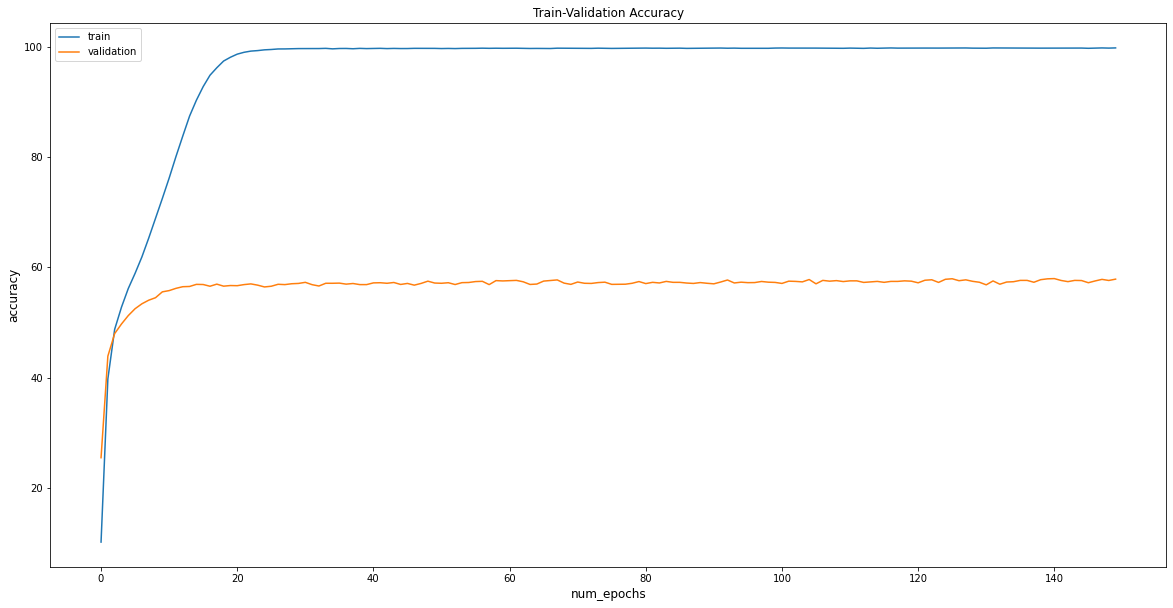

In [8]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

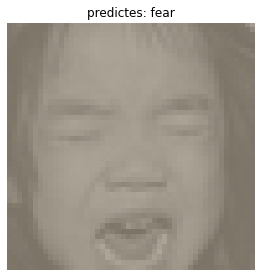

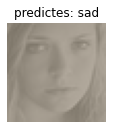

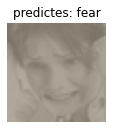

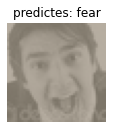

In [9]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()